In [1]:
from src.arguments import ModelArguments, DataArguments
from src.model.model import MMEBModel
from src.model.processor import load_processor, QWEN2_VL, VLM_IMAGE_TOKENS, Qwen2_VL_process_fn
from src.utils.basic_utils import batch_to_device
from PIL import Image
import numpy as np
import torch
import math
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn.functional as F

from transformers.image_transforms import (
    convert_to_rgb,
    resize,
)

/opt/conda/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/workspace/VLM2Vec/src/model/baseline_backbone/internvideo2/modeling_internvideo2.py:539: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
[2025-12-25 10:12:29,840] DEBUG [matplotlib:342] matplotlib data path: /opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data
[2025-12-25 10:12:29,846] DEBUG [matplotlib:342] CONFIGDIR=/root/.config/matplotlib
[2025-12-25 10:12:29,858] DEBUG [matplotlib:1560] interactive is False
[2025-12-25 10:12:29,859] DEBUG [matplotlib:1561] platform is linux
[2025-12-25 10:12:29,878] DEBUG [matplotlib:342] CACHEDIR=/root/.cache/matplotlib
[2025-12-25 10:12:29,879] DEBUG [m

DropoutAddRMSNorm of flash_attn is not installed!!!


[2025-12-25 10:12:30,072] DEBUG [matplotlib.pyplot:496] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-12-25 10:12:30,075] DEBUG [matplotlib.pyplot:496] Loaded backend inline version unknown.


In [2]:
model_args = ModelArguments(
    model_name='Qwen/Qwen2-VL-2B-Instruct',
    checkpoint_path='TIGER-Lab/VLM2Vec-Qwen2VL-2B',
    pooling='last',
    normalize=True,
    model_backbone='qwen2_vl',
    lora=True
)
data_args = DataArguments()

processor = load_processor(model_args, data_args)
model = MMEBModel.load(model_args)
model = model.to('cuda', dtype=torch.bfloat16)
model.eval()

[2025-12-25 10:12:30,086] INFO [src.utils.basic_utils:21] Loading processor from: TIGER-Lab/VLM2Vec-Qwen2VL-2B
[2025-12-25 10:12:30,089] DEBUG [urllib3.connectionpool:1051] Starting new HTTPS connection (1): huggingface.co:443
[2025-12-25 10:12:31,939] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /TIGER-Lab/VLM2Vec-Qwen2VL-2B/resolve/main/preprocessor_config.json HTTP/11" 307 0
[2025-12-25 10:12:32,153] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /api/resolve-cache/models/TIGER-Lab/VLM2Vec-Qwen2VL-2B/7717deedf0631e6f520b7c83c8f82dcbc2c4c21e/preprocessor_config.json HTTP/11" 200 0
[2025-12-25 10:12:32,539] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /TIGER-Lab/VLM2Vec-Qwen2VL-2B/resolve/main/tokenizer_config.json HTTP/11" 307 0
[2025-12-25 10:12:32,752] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /api/resolve-cache/models/TIGER-Lab/VLM2Vec-Qwen2VL-2B/7717deedf0631e6f520b7c83c8f82dcbc2c4c21e/to

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[2025-12-25 10:12:39,494] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /Qwen/Qwen2-VL-2B-Instruct/resolve/main/generation_config.json HTTP/11" 307 0
[2025-12-25 10:12:39,702] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /api/resolve-cache/models/Qwen/Qwen2-VL-2B-Instruct/895c3a49bc3fa70a340399125c650a463535e71c/generation_config.json HTTP/11" 200 0
[2025-12-25 10:12:39,705] INFO [src.utils.basic_utils:21] Loading LoRA from TIGER-Lab/VLM2Vec-Qwen2VL-2B
[2025-12-25 10:12:40,060] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /TIGER-Lab/VLM2Vec-Qwen2VL-2B/resolve/main/adapter_config.json HTTP/11" 307 0
[2025-12-25 10:12:40,282] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /api/resolve-cache/models/TIGER-Lab/VLM2Vec-Qwen2VL-2B/7717deedf0631e6f520b7c83c8f82dcbc2c4c21e/adapter_config.json HTTP/11" 200 0
[2025-12-25 10:12:46,238] DEBUG [urllib3.connectionpool:546] https://huggingface.co:443 "HEAD /TIGER-

MMEBModel(
  (encoder): PeftModel(
    (base_model): LoraModel(
      (model): Qwen2VLForConditionalGeneration(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionSdpaAttention(
                (qkv): Linear(in_features=1280, out_features=3840, bias=True)
                (proj): Linear(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): VisionMlp(
                (fc1): Linear(in_features=1280, out_features=5120, bias=True)
                (act): QuickGELUActivation()
                (fc2): Linear(in_

In [3]:
model.encoder.visual

Qwen2VisionTransformerPretrainedModel(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
  )
  (rotary_pos_emb): VisionRotaryEmbedding()
  (blocks): ModuleList(
    (0-31): 32 x Qwen2VLVisionBlock(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): VisionSdpaAttention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (mlp): VisionMlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): QuickGELUActivation()
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      )
    )
  )
  (merger): PatchMerger(
    (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=5120, out_features=5120, bias=True)
      (1): GEL

In [4]:
image = Image.open('assets/example.jpg')

In [5]:
# Image + Text -> Text
inputs = processor(text=f'{VLM_IMAGE_TOKENS[QWEN2_VL]} Represent the given image with the following question: What is in the image',
                   images=image.copy(),
                   return_tensors="pt")
# inputs = processor(text=f'Represent the given image with the following question: What is in the image',
#                    return_tensors="pt")
inputs = {key: value.to('cuda') for key, value in inputs.items()}
inputs['pixel_values'] = inputs['pixel_values'].unsqueeze(0)
inputs['image_grid_thw'] = inputs['image_grid_thw'].unsqueeze(0)
inputs.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

In [6]:
# multi_inputs = {
#     "text": [f'{VLM_IMAGE_TOKENS[QWEN2_VL]} Represent the given image with the following question: What is in the image',
#           f'{VLM_IMAGE_TOKENS[QWEN2_VL]} What is representation of in the image?'],
#     "images": [Image.open('assets/example.jpg'),
#             Image.open('assets/example.jpg')],
# }
# multi_inputs = Qwen2_VL_process_fn(
#     multi_inputs,
#     processor)

# print(multi_inputs.keys())
# print((multi_inputs['input_ids']))
# print(multi_inputs['attention_mask'])
# --> left padding

In [7]:
processor

Qwen2VLProcessor:
- image_processor: Qwen2VLImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "Qwen2VLImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "max_pixels": 1003520,
  "merge_size": 2,
  "min_pixels": 3136,
  "patch_size": 14,
  "processor_class": "Qwen2VLProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1003520,
    "shortest_edge": 3136
  },
  "temporal_patch_size": 2
}

- tokenizer: Qwen2TokenizerFast(name_or_path='TIGER-Lab/VLM2Vec-Qwen2VL-2B', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_star

In [8]:
print(image.size)
print(inputs['image_grid_thw'])
print(inputs['pixel_values'].shape)
print(inputs['input_ids'].shape)

(800, 599)
tensor([[[ 1, 42, 58]]], device='cuda:0')
torch.Size([1, 2436, 1176])
torch.Size([1, 623])


In [9]:
print(inputs['input_ids'])
print(model.config.image_token_id)
print((inputs['input_ids']==model.config.image_token_id).sum())

attn = inputs["attention_mask"]
num_pad = (attn == 0).sum()
print(num_pad)

tensor([[151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151

In [10]:
def smart_resize(
    height: int, width: int, factor: int = 28, min_pixels: int = 56 * 56, max_pixels: int = 14 * 14 * 4 * 1280
):
    """Rescales the image so that the following conditions are met:
    1. Both dimensions (height and width) are divisible by 'factor'.
    2. The total number of pixels is within the range ['min_pixels', 'max_pixels'].
    3. The aspect ratio of the image is maintained as closely as possible.
    """
    if height < factor or width < factor or max(height, width) / min(height, width) > 200:
        # extreme cases, resize to a square
        height = width = max(factor, height, width)
    h_bar = round(height / factor) * factor
    w_bar = round(width / factor) * factor
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = math.floor(height / beta / factor) * factor
        w_bar = math.floor(width / beta / factor) * factor
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = math.ceil(height * beta / factor) * factor
        w_bar = math.ceil(width * beta / factor) * factor
    return h_bar, w_bar

In [11]:
image_processor = processor.image_processor

In [12]:
image = np.array(image)
print(image.shape)

(599, 800, 3)


In [13]:
height, width = image.shape[0], image.shape[1]

patch_size = image_processor.patch_size
merge_size = image_processor.merge_size
temporal_patch_size = image_processor.temporal_patch_size # 2
size = image_processor.size

print("original size:", height, width)
print("patch size:", patch_size)
print("merge size:", merge_size)
print("temporal patch size:", temporal_patch_size)

resized_height, resized_width = smart_resize(
                    height,
                    width,
                    factor=patch_size * merge_size,
                    min_pixels=size["shortest_edge"],
                    max_pixels=size["longest_edge"],
                )


processed_image = resize(image, size=(resized_height, resized_width), 
               resample=image_processor.resample, 
               input_data_format="channels_last")

print(processed_image.shape)

# rescale_factor = image_processor.rescale_factor
# processed_image = image_processor.rescale(processed_image, 
#                                           scale=rescale_factor,
#                                           input_data_format="channels_last")

# print(rescale_factor, processed_image.shape)


patches = np.array([processed_image])
patches = patches.transpose(0, 3, 1, 2)
if patches.shape[0] % temporal_patch_size != 0:
    repeats = np.repeat(
        patches[-1][np.newaxis], temporal_patch_size - (patches.shape[0] % temporal_patch_size), axis=0
    )
    patches = np.concatenate([patches, repeats], axis=0)


print("shape before patchify:", patches.shape)

channel = patches.shape[1]
grid_t = patches.shape[0] // temporal_patch_size
grid_h, grid_w = resized_height // patch_size, resized_width // patch_size
patches = patches.reshape(
    grid_t,
    temporal_patch_size,
    channel,
    grid_h // merge_size,
    merge_size,
    patch_size,
    grid_w // merge_size,
    merge_size,
    patch_size,
)
patches = patches.transpose(0, 3, 6, 4, 7, 2, 1, 5, 8)
flatten_patches = patches.reshape(
    grid_t * grid_h * grid_w, channel * temporal_patch_size * patch_size * patch_size
)

print("shape after patchify:", flatten_patches.shape)


original size: 599 800
patch size: 14
merge size: 2
temporal patch size: 2
(588, 812, 3)
shape before patchify: (2, 3, 588, 812)
shape after patchify: (2436, 1176)


In [14]:
# must comment _attn_implementation in src/model/model.py/MMEBModel.load/ to return outputs_attention

hidden_states = model.encoder(**inputs, return_dict=True, output_hidden_states=True, output_attentions=True)
hidden_states.keys()

[2025-12-25 10:15:03,607] WARNING [src.model.vlm_backbone.qwen2_vl.modeling_qwen2_vl:329] Qwen2VLModel is using Qwen2VLSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


odict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions', 'rope_deltas'])

Get the attention from last token to image token 

In [15]:
attention_weights = torch.stack([hidden_states['attentions'][i].squeeze(0) 
                                for i in range(len(hidden_states['attentions']))], dim=0) # [layer, head, seq_len, seq_len]

img_token_len = (inputs['input_ids']==model.config.image_token_id).sum().item()
img_input_shape = inputs['image_grid_thw'][0, 0, 1:] # get the img input grid shape 

img_hidden_grid = img_input_shape // merge_size 

print(img_token_len)
print(img_hidden_grid)


609
tensor([21, 29], device='cuda:0')


In [16]:
# 1. Xác định vị trí bắt đầu và kết thúc của Image Tokens trong sequence
input_ids = inputs['input_ids'][0] # Lấy batch đầu tiên
image_token_id = model.config.image_token_id

# Tìm các index mà tại đó là image token
img_indices = (input_ids == image_token_id).nonzero(as_tuple=True)[0]

img_start = img_indices[0].item()
img_end = img_indices[-1].item() + 1 # +1 để dùng cho slicing

print(f"Image starts at: {img_start}, ends at: {img_end}")
print(f"Number of image tokens: {img_end - img_start}") # Phải bằng 1131


Image starts at: 0, ends at: 609
Number of image tokens: 609


[2025-12-25 10:15:31,960] DEBUG [matplotlib.font_manager:1471] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2025-12-25 10:15:31,961] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2025-12-25 10:15:31,962] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
[2025-12-25 10:15:31,963] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', var

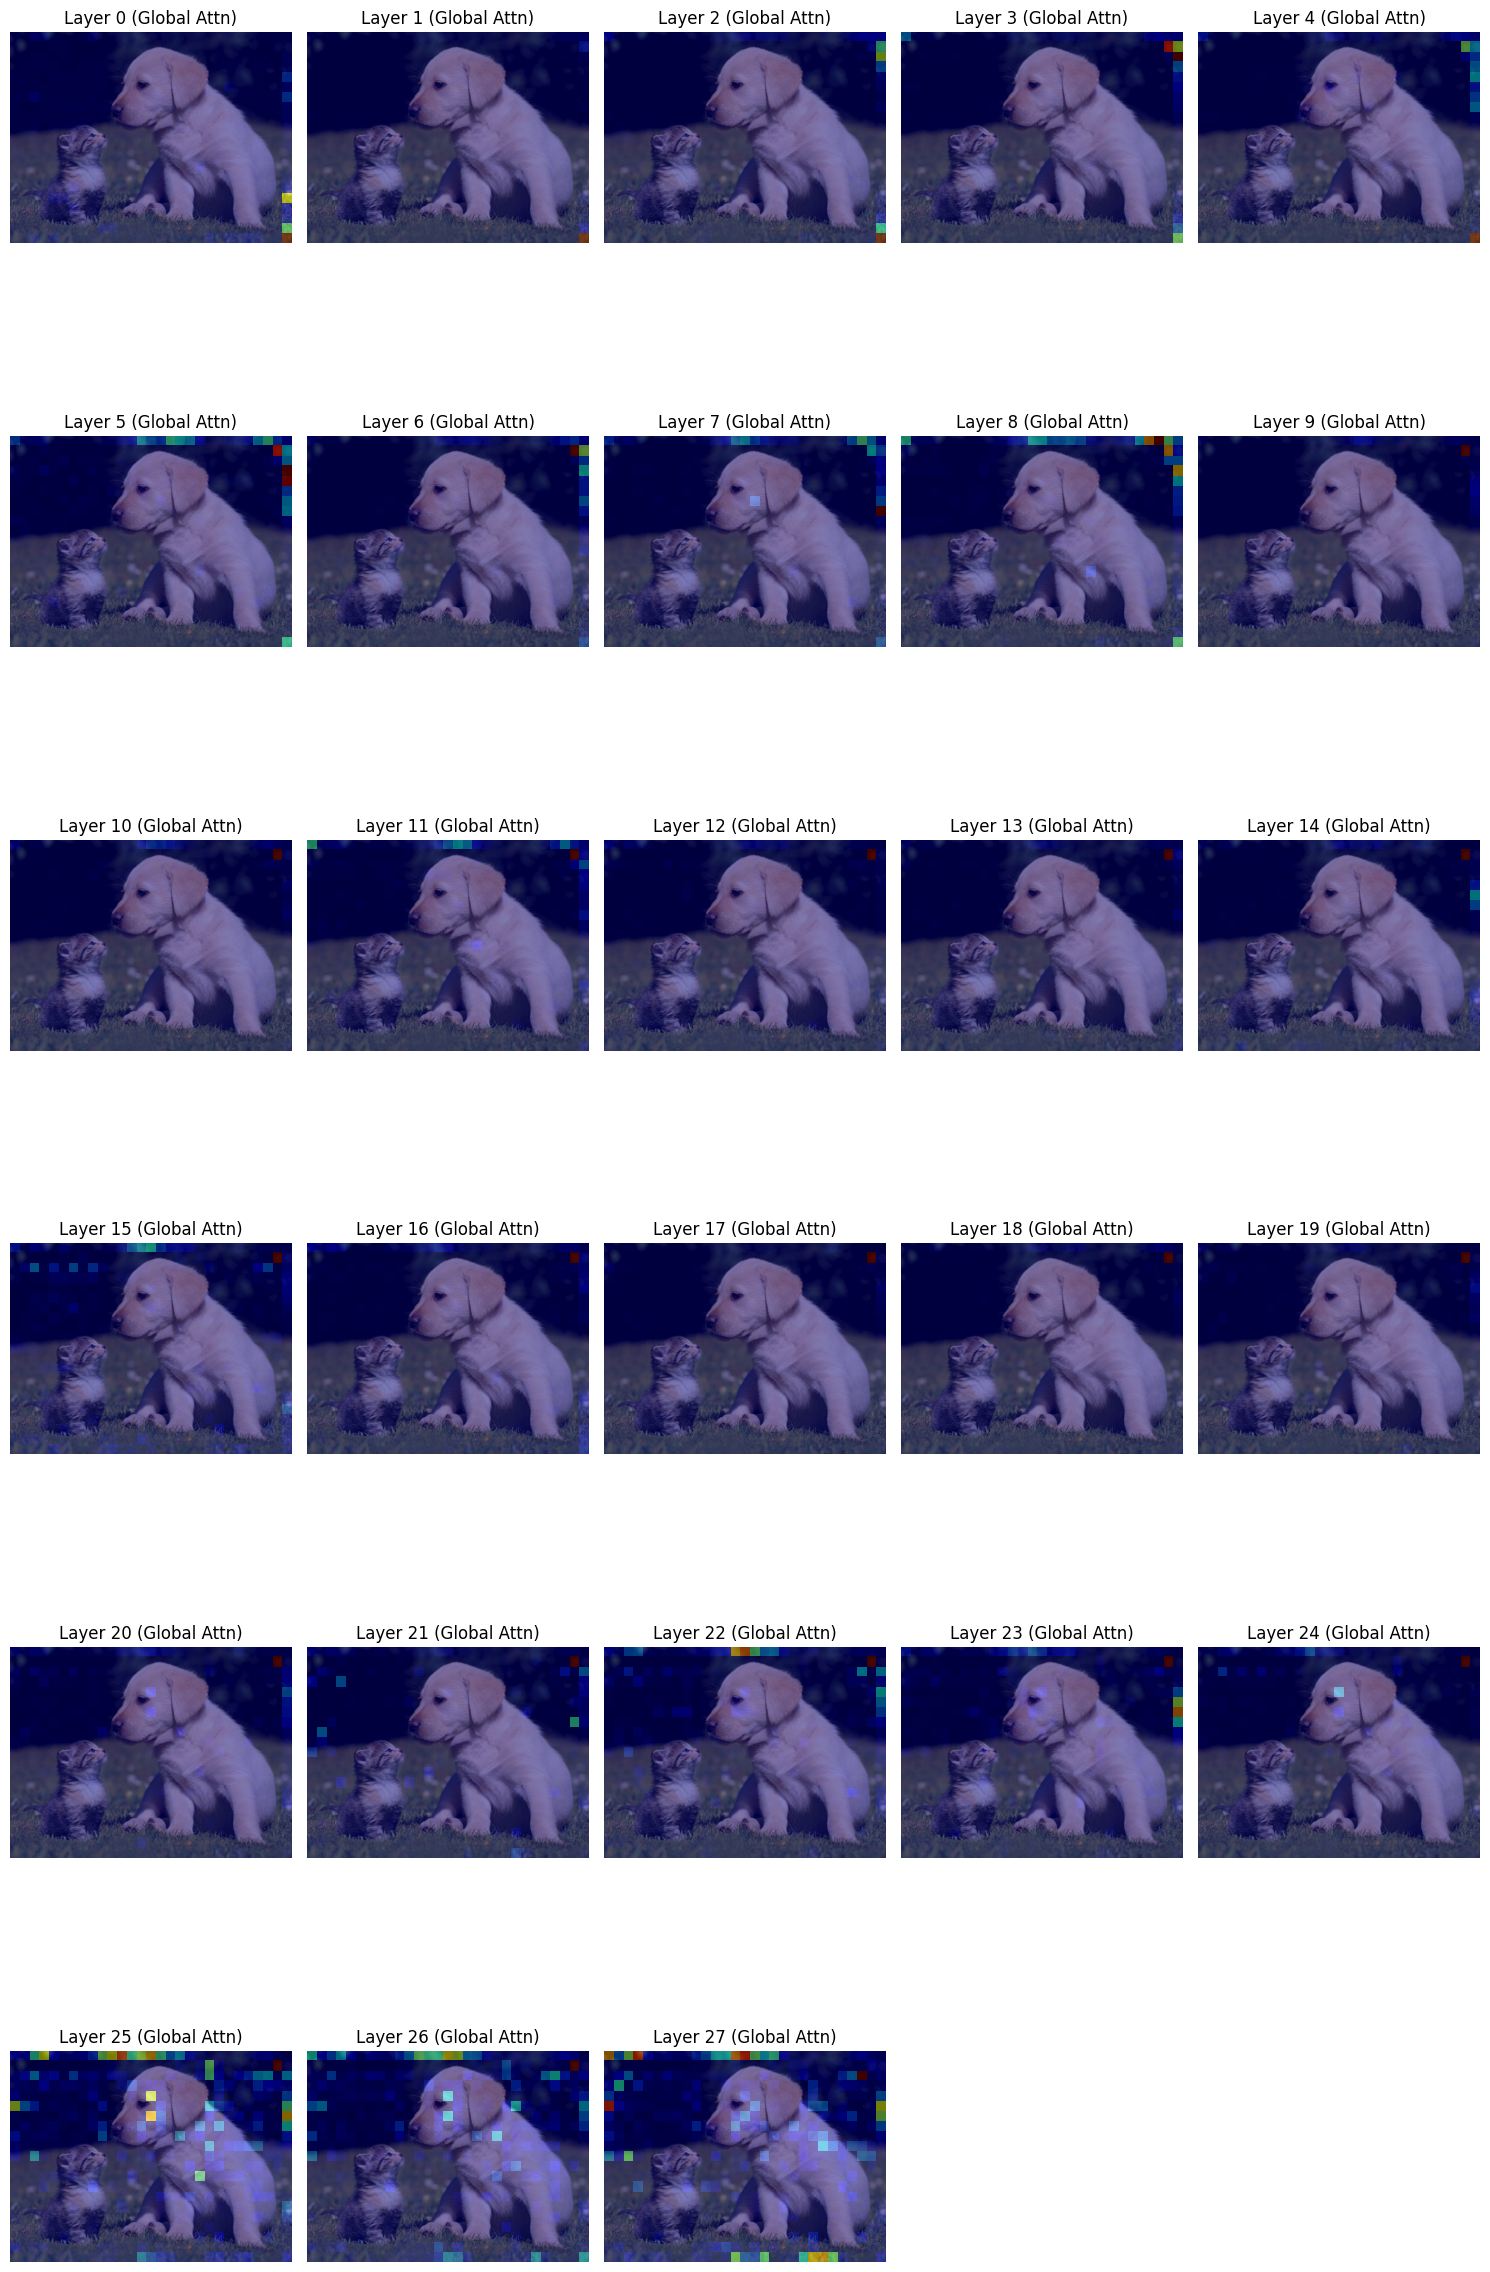

In [17]:
# Danh sách layer muốn kiểm tra
target_layers = range(0, 28)

plt.figure(figsize=(15, 25))

for idx, layer_i in enumerate(target_layers):
    # Lấy attention của layer đó
    # Cách tiếp cận: Global Image Attention (Cách 2)
    # Xem các token ảnh tự chú ý vào đâu nhiều nhất
    curr_attn = attention_weights[layer_i, :, -1, img_start:img_end] # [head, img_token_len]
    attn_map = curr_attn.mean(dim=0) # [1131]
    
    # Reshape & Resize
    h_grid, w_grid = img_hidden_grid[0].item(), img_hidden_grid[1].item()
    attn_heatmap = attn_map.view(1, 1, h_grid, w_grid)
    
    pixel_heatmap = F.interpolate(
        attn_heatmap,
        size=(image.shape[0], image.shape[1]),
        mode='nearest' # Dùng nearest để thấy rõ ô vuông
    ).squeeze().float().detach().cpu().numpy()
    
    # Normalize
    pixel_heatmap = (pixel_heatmap - pixel_heatmap.min()) / (pixel_heatmap.max() - pixel_heatmap.min())
    
    # Plot
    plt.subplot(6, 5, idx+1)
    plt.imshow(image)
    plt.imshow(pixel_heatmap, cmap='jet', alpha=0.5, interpolation='nearest')
    plt.title(f"Layer {layer_i} (Global Attn)")
    plt.axis('off')

plt.tight_layout()
plt.show()

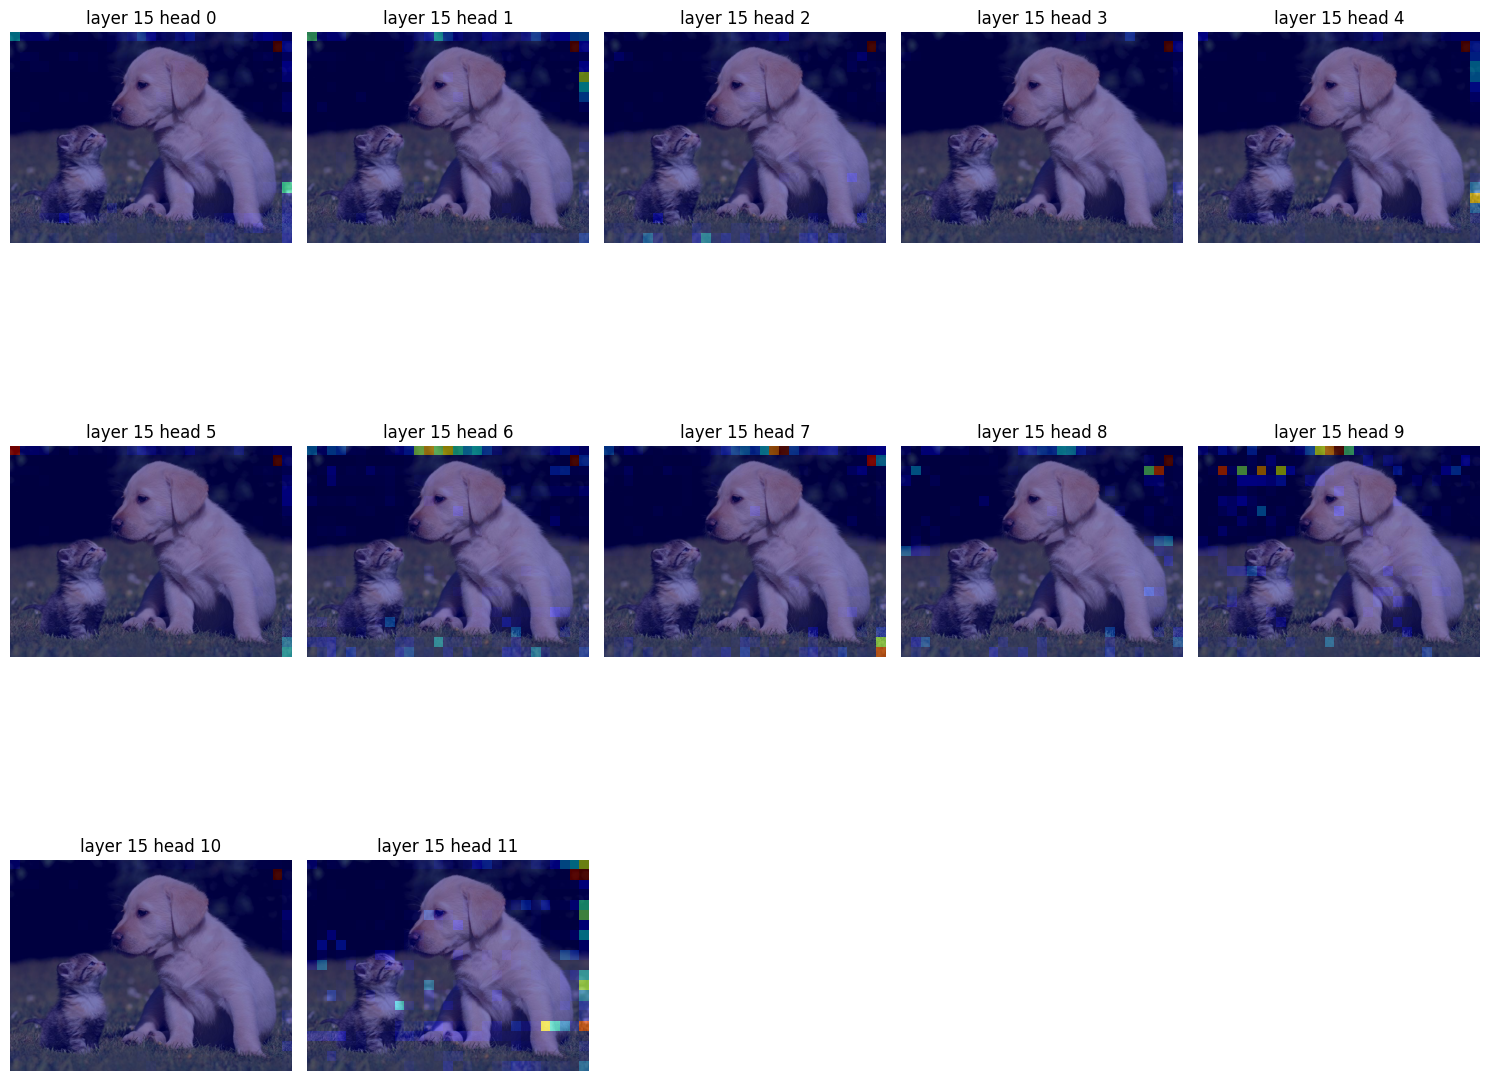

In [22]:
# kiểm tra từng head của mỗi layer
target_layer = 15
num_head = attention_weights.shape[1]
plt.figure(figsize=(15, 25))

for head_i in range(num_head):
    # Lấy attention của layer đó
    # Cách tiếp cận: Global Image Attention (Cách 2)
    # Xem các token ảnh tự chú ý vào đâu nhiều nhất
    curr_attn = attention_weights[target_layer, head_i, -1, img_start:img_end] # [img_token_len]
    # attn_map = curr_attn.mean(dim=0) # [1131]
    
    # Reshape & Resize
    h_grid, w_grid = img_hidden_grid[0].item(), img_hidden_grid[1].item()
    attn_heatmap = curr_attn.view(1, 1, h_grid, w_grid)
    
    pixel_heatmap = F.interpolate(
        attn_heatmap,
        size=(image.shape[0], image.shape[1]),
        mode='nearest' # Dùng nearest để thấy rõ ô vuông
    ).squeeze().float().detach().cpu().numpy()
    
    # Normalize
    pixel_heatmap = (pixel_heatmap - pixel_heatmap.min()) / (pixel_heatmap.max() - pixel_heatmap.min())
    
    # Plot
    plt.subplot(6, 5, head_i+1)
    plt.imshow(image)
    plt.imshow(pixel_heatmap, cmap='jet', alpha=0.5, interpolation='nearest')
    plt.title(f"layer {target_layer} head {head_i}")
    plt.axis('off')

plt.tight_layout()
plt.show()